In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
print(sys.version)


3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]


In [2]:
# Set file directories:
outputDir = "../output"
dataDir = "../data"
tag = "lipid_concentration"

In [3]:
SMALL_VALUE = 1e-10

# File contents
The raw data were from ../data/*
Files include:
1. UNAZ-03-24VWCLP+ BRAIN DATA TABLES (GLOBAL).XLSX: Global metabolite
2. UNAZ-03-24VWCLP+ BRAIN HEATMAP (CLP).XLSX
3. UNAZ-03-24VWCLP+ BRAIN HEATMAP (GLOBAL).XLSX
4. UNAZ-03-24VWCLP+ BRAIN SIX TAB FILE (CLP DATA).XLSX
5. UNAZ-03-24VWCLP+ PLASMA DATA TABLES (GLOBAL).XLSX
6. UNAZ-03-24VWCLP+ PLASMA HEATMAP (CLP).XLSX
7. UNAZ-03-24VWCLP+ PLASMA HEATMAP (GLOBAL).XLSX
8. UNAZ-03-24VWCLP+ PLASMA SIX TAB FILE (CLP DATA).XLSX
9. UNAZ-03-24VWCLP+ REPORT_16DEC24.DOCX

From the report, "An equal volume of all plasma samples, and an equal mass of all cortex samples were prepared for analysis on each platform, therefore no additional normalization of the data was performed prior to statistical analysis". 
So this processing file only deal with the meta data, extract the normalized expressions of each metabolites

## Data processing from the report:
*Batch Normalization*: To remove batch variability, for each metabolite, the values in the experimental samples are divided by the median of those samples in each instrument batch, giving each batch and thus the metabolite a median of one.  

*Volumn Normalization*: For each sample, the Batch-normalized data is divided by the value of the normalizer. Since "An equal volume of all plasma samples, and an equal mass of all cortex samples were prepared for analysis on each platform", the value of the normalizer is 1. Then each metabolite is re-scaled to have median = 1 (divide the new values by the overall median for each metabolite). 

*Missing Value imputation*:For each metabolite, the minimum value across all batches in the median scaled data is imputed for the missing values

*log transformation*:The Batch-norm-Imputed Data (or protein, volume, etc. normalized data if applicable) is transformed using the natural log. Metabolomic data typically displays a log-normal distribution, therefore, the log-transformed data is used for statistical analyses.


# Data Processing

In [4]:

# Define the data directory and file name
filename = "UNAZ-03-24VWCLP+ BRAIN SIX TAB FILE (CLP DATA).XLSX"
filepath = os.path.join(dataDir, filename)


In [5]:

# Load the Excel file
# Lipid Class Concentrations
# Species Concentrations
# Fatty Acid Concentrations
sheet_name = "Species Concentrations"  # Replace with the name of the sheet you want to read
N_rows = 931
# Read the Excel file
df = pd.read_excel(filepath, sheet_name=sheet_name, header=None)


# Extract metadata (rows 6 to 21, excluding the first 2 columns)
metadata = df.iloc[5:21, 3:].copy().T  # Transpose the metadata
metadata.columns = df.iloc[5:21, 2].tolist()  # Set the header row (row 5) as column names
metadata.index = df.iloc[9, 3:].tolist()  # Set the sample names as the index
#metadata.index.name = "Sample Name"  # Name the index

# Extract chemical names and classes (rows 23 to 36, first 2 columns)
chemical_info = df.iloc[22:N_rows, 0:2].copy()
chemical_info.columns = df.iloc[21, :2].tolist() # Set column names
chemical_info.set_index("Name", inplace=True)  # Set chemical names as the index

# Extract data (rows 23 to 36, excluding the first 3 columns)
data = df.iloc[22:N_rows, 3:].copy().T  # Transpose the data
data.columns = df.iloc[22:N_rows, 1].tolist()  # Set the chemical names as column names
data.index = df.iloc[9, 3:].tolist()  # Set the sample names as the index
#data.index.name = "Sample Name"  # Name the index

# Display the extracted data
print("Metadata:")
print(metadata)
print("\nChemical Information:")
print(chemical_info)
print("\nData:")
print(data)

Metadata:
       CLIENT IDENTIFIER AMOUNT EXTRACTED CLP  BOX NUMBER CLIENT MATRIX  \
GL7271        4079063452                   75  5500038776        Tissue   
LR9936        4079063700                   75  5500038776        Tissue   
AT7960        4079063453                   75  5500038776        Tissue   
GI3935        4079063701                   75  5500038776        Tissue   
WA1094        4079063454                   75  5500038776        Tissue   
...                  ...                  ...         ...           ...   
WA1220        4079062770                   75  5500236975        Tissue   
QQ2973        4088330445                   75  5500236975        Tissue   
LS0975        4068148888                   75  5500236975        Tissue   
VU5737        4088330454                   75  5500236975        Tissue   
LK8235        4079062771                   75  5500236975        Tissue   

       CLIENT SAMPLE ID CLIENT SAMPLE NUMBER GENOTYPE          GROUP ID  \
GL7271        

In [6]:
# Show all rows
pd.set_option('display.max_rows', None)

# Print the full result
print(data[["TAG50:2-FA14:0"]])

# Reset the option if needed
pd.reset_option('display.max_rows')

       TAG50:2-FA14:0
GL7271            NaN
LR9936       0.032269
AT7960       0.023421
GI3935       0.014042
WA1094            NaN
LP6894       0.017168
LK8321       0.017433
VR5134       0.042867
LH2255            NaN
GL7281       0.021248
WD5671            NaN
LR9932            NaN
AT8466            NaN
BF1129            NaN
GI3930            NaN
GI3169       0.026653
QQ2135       0.038999
LS0973            NaN
LK8215       0.023579
QS3424       0.031687
QX5395       0.022096
BH8637            NaN
LM7019       0.039582
GG7154            NaN
QS2654            NaN
GE7910       0.022626
WD6110            NaN
QQ2979            NaN
GH3357            NaN
QX5393            NaN
WD5676       0.019684
LP6895       0.119308
QU7375            NaN
QU7374            NaN
LP6322       0.013658
AW4999       0.071705
BD2768       0.037158
QM2116       0.018278
LS0971       0.054632
WD5673       0.085564
WD5678       0.009239
QJ7629       0.033342
WA1238       0.067487
QU7590        0.03535
GI4069    

In [7]:
min_value = data[["TAG50:2-FA14:0"]].min(skipna=True).values[0]

print(f"{min_value:.6e}") 

5.946494e-18


In [8]:
metadata["GROUP NUMBER"].value_counts()

GROUP NUMBER
1     6
2     6
3     6
4     6
6     6
7     6
8     6
9     6
10    6
11    6
14    6
5     5
12    5
13    5
15    5
Name: count, dtype: int64

In [9]:
# Fill all small values with NAN
data[data < SMALL_VALUE] = np.nan


## Data imputation

1. For mising data with >50% missing values and at least 1 missing in each group, remove that metabolites
2. For other missing value, imputed with 50% of minimum positive.



In [10]:
nan_percentage = data.isna().mean() * 100
print(nan_percentage)

CER(14:0)          17.441860
CER(16:0)           0.000000
CER(18:0)           0.000000
CER(18:1)           0.000000
CER(20:0)           0.000000
                     ...    
TAG60:10-FA22:5    72.093023
TAG60:10-FA22:6     0.000000
TAG60:11-FA22:5    29.069767
TAG60:11-FA22:6     1.162791
TAG60:12-FA22:6     0.000000
Length: 909, dtype: float64


In [11]:
(nan_percentage>50).mean() #51% of the columns have more than 20% missing values
# 36% of the columns have more than 50% missing values

0.35973597359735976

Text(0.5, 1.0, 'Proportion of metabolites vs data completeness')

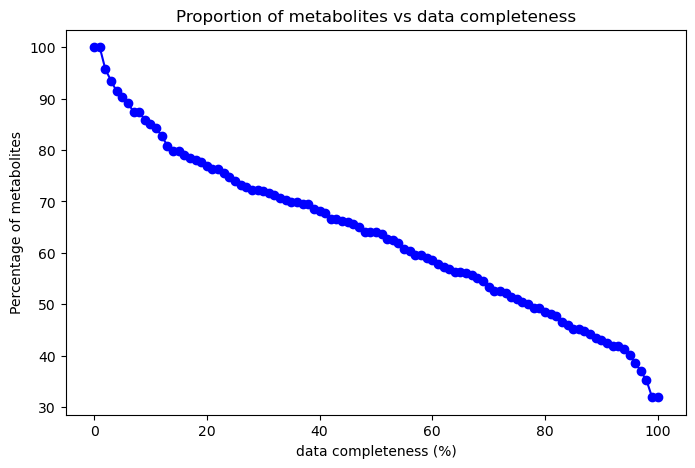

In [12]:
nan_percentage_sorted = nan_percentage.sort_values()

# Compute the proportion of variables with more than a given NaN percentage
x_values = np.arange(0, 101, 1)  # X-axis from 0% to 100%
y_values = [((100-nan_percentage_sorted) >= x).mean() * 100 for x in x_values]  # Y-axis as percentage of variables

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
plt.xlabel("data completeness (%)")
plt.ylabel("Percentage of metabolites")
plt.title("Proportion of metabolites vs data completeness")

In [13]:
# Remove metabolites with too much missing values
# 1. > 50% missing values
# 2. And at least 1 missing value in each group
# Compute the percentage of NaNs in each column
nan_percentage = data.isna().mean() * 100

# Step 1: Remove columns with more than 50% NaNs
filtered_data = data.loc[:, nan_percentage <= 50]

# Step 2: Remove columns that have at least one missing value in every group
grouped_nan_counts = data.isna().groupby(metadata["GROUP NUMBER"]).sum()  # Count NaNs per group
cols_atLeastOneGroupFull = grouped_nan_counts.min() == 0  # Keep columns where at least one group has full data

cols_to_keep = (nan_percentage <= 50) | cols_atLeastOneGroupFull
# Apply the filtering
filtered_data = data.loc[:, cols_to_keep]

#filtered_data = filtered_data.loc[:, cols_to_keep]

print(f"Remaining variables: {filtered_data.shape}") #504 metabolites remaining

Remaining variables: (86, 584)


In [14]:
# Data imputation
filtered_data = filtered_data.infer_objects(copy=False)

# Compute 0.5 * minimum for each column (ignoring NaNs)
impute_values = 0.5 * filtered_data.min(skipna=True)

# Fill NaNs with computed values
filtered_data_filled = filtered_data.fillna(impute_values)



In [15]:
min_values = filtered_data.min(skipna=True)  # Minimum values per column
min_samples = filtered_data.idxmin(skipna=True)  # Corresponding sample names (row index)

# Combine into a DataFrame for better visualization
min_summary = pd.DataFrame({'Sample': min_samples, 'Min Value': min_values})

pd.set_option('display.max_rows', None)
# Display the result
print(min_summary)
# Reset the option if needed
pd.reset_option('display.max_rows')


                 Sample   Min Value
CER(14:0)        LS0971    0.003175
CER(16:0)        LK8235    0.067871
CER(18:0)        LK8235    3.520429
CER(18:1)        LK8235    0.024034
CER(20:0)        LK8235    0.171462
CER(20:1)        GL7273    0.022748
CER(22:0)        LK8235    0.098605
CER(22:1)        QU7375    0.103843
CER(24:0)        LK8235    0.059928
CER(24:1)        WD5678    0.293118
CER(26:0)        BF0876    0.004186
CER(26:1)        BH8623    0.007600
CE(12:0)         WA1094    0.068288
CE(14:0)         VR5136    0.001667
CE(14:1)         LS0971    0.000564
CE(15:0)         WD5676    0.000342
CE(16:0)         LR9932    0.062180
CE(16:1)         LK8235    0.017926
CE(17:0)         QX5393    0.003131
CE(18:0)         LM7019    0.005352
CE(18:1)         LK8235    0.119208
CE(18:2)         LS0975    0.008569
CE(18:3)         LS0975    0.000504
CE(18:4)         AT8466    0.000140
CE(20:0)         GE7912    0.002788
CE(20:1)         GL7282    0.000534
CE(20:2)         BF0875    0

In [16]:
# Show all rows
pd.set_option('display.max_rows', None)

# Print the full result
print(filtered_data.columns[filtered_data.min(skipna=True) < 1e-10])
# Reset the option if needed
pd.reset_option('display.max_rows')

Index([], dtype='object')


In [18]:
tag

'lipid_concentration'

In [19]:
chemical_info_lipid_filter = chemical_info.loc[cols_to_keep,:]
chemical_info_lipid_filter.to_csv("chemical_info_"+tag+".csv")

chemical_info_lipid_filter.to_csv(os.path.join(outputDir,"chemical_info_"+tag+".csv"))
filtered_data_filled.to_csv(os.path.join(outputDir,"data_"+tag+".csv"))


# Data visualization

## Log2 transformation

In [20]:

# Avoid log transformation on zero values by adding a small constant
small_value = filtered_data_filled[filtered_data_filled > 0].min().min() * 0.5
log2_transformed_data = np.log2(filtered_data_filled.replace(0, small_value))

#log2_transformed_data2 = np.log2(filtered_data_filled)



<Axes: ylabel='Count'>

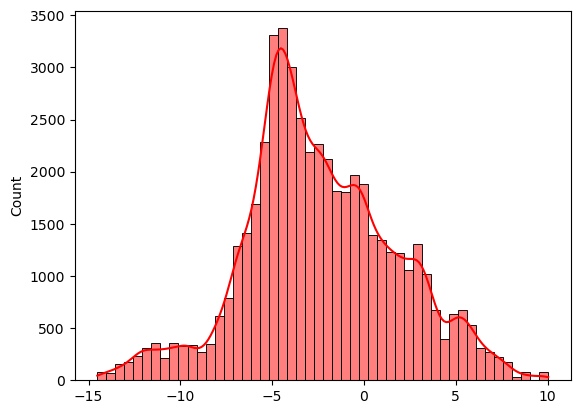

In [21]:

sns.histplot(log2_transformed_data.values.flatten(), bins=50, kde=True,  color="red")


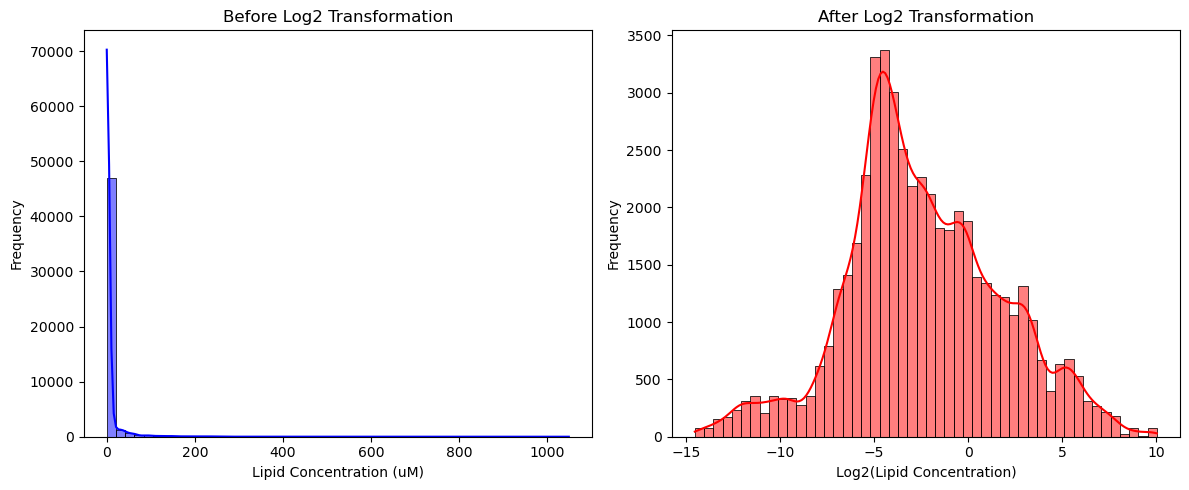

In [22]:
# Create subplots for before and after transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram before log2 transformation
sns.histplot(filtered_data_filled.values.flatten(), bins=50, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Before Log2 Transformation")
axes[0].set_xlabel("Lipid Concentration (uM)")
axes[0].set_ylabel("Frequency")

# Histogram after log2 transformation
sns.histplot(log2_transformed_data.values.flatten(), bins=50, kde=True, ax=axes[1], color="red")
axes[1].set_title("After Log2 Transformation")
axes[1].set_xlabel("Log2(Lipid Concentration)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


## boxplot

When you call plt.show(), Matplotlib displays the plot and then clears the figure from memory. If you try to save the plot after calling plt.show(), there's nothing left to save, resulting in an empty PDF.

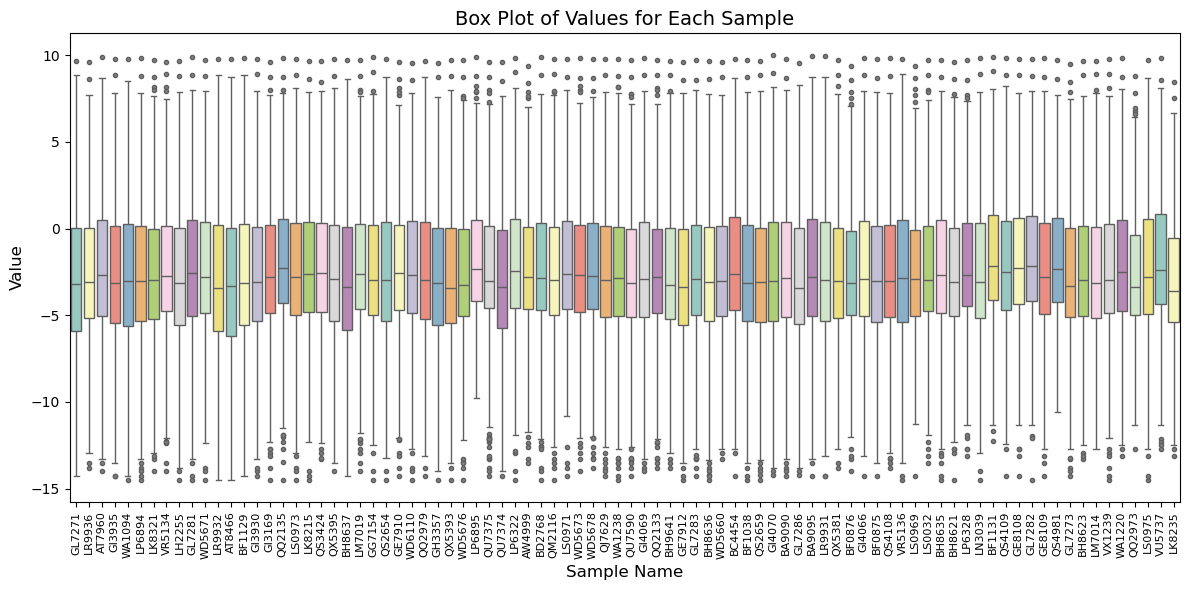

In [23]:
data_transposed = log2_transformed_data.T

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_transposed, palette="Set3",flierprops=dict(marker='.', markerfacecolor='grey',linestyle='none'))
plt.title("Box Plot of Values for Each Sample", fontsize=14)
plt.xlabel("Sample Name", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(rotation=90,fontsize=8)  # Rotate sample names for better readability
plt.tight_layout() #Adjust the layout to prevent overlapping of labels.
plt.savefig(os.path.join(outputDir, "boxplot_"+tag+"_samples.pdf"))
plt.show()

plt.close()

In [24]:
log2_transformed_data.T.head()


,GL7271,LR9936,AT7960,GI3935,WA1094,LP6894,LK8321,VR5134,LH2255,GL7281,...,QS4981,GL7273,BH8623,LM7014,VX1239,WA1220,QQ2973,LS0975,VU5737,LK8235
CER(14:0),-7.550747,-6.819564,-9.298911,-6.751659,-9.298911,-9.298911,-9.298911,-9.298911,-5.655444,-9.298911,...,-6.652709,-7.283475,-9.298911,-6.933891,-6.989744,-6.318808,-7.778240,-6.551171,-6.828281,-9.298911
CER(16:0),-2.488283,-2.645106,-2.017242,-2.149975,-2.302874,-1.873348,-2.309610,-1.832891,-0.783604,-2.239328,...,-1.942257,-1.826645,-2.299079,-2.177857,-2.295342,-1.294596,-2.931197,-2.184062,-1.884977,-3.881051
CER(18:0),3.200106,3.027273,3.411026,3.619297,3.468075,3.800721,3.529656,3.924587,4.690099,3.405628,...,3.655502,3.928488,3.285943,3.739024,3.629406,4.371598,2.881726,3.535737,3.978501,1.815751
CER(18:1),-4.018964,-4.507950,-3.799537,-3.802084,-4.033853,-3.675279,-3.972327,-3.241109,-2.950975,-3.645246,...,-3.417189,-4.218184,-4.679955,-4.044367,-3.744159,-3.311137,-4.586443,-4.044367,-3.242946,-5.378786
CER(20:0),-1.497981,-1.512281,-1.208265,-1.173393,-1.120493,-0.968066,-1.055549,-0.894018,-0.294332,-1.132201,...,-1.182010,-1.159097,-1.443148,-1.005351,-1.107108,-0.481570,-1.855029,-1.240772,-0.781281,-2.544038


In [ ]:
metadata.to_csv(os.path.join(outputDir,"metadata_"+tag+".csv"))
log2_transformed_data.to_csv(os.path.join(outputDir,"data_log_"+tag+".csv"))

## PCA

Note for **confidence ellipses** that represent the distribution of points for each group. To achieve this, you can use the matplotlib.patches.Ellipse class and calculate the ellipse parameters (center, width, height, and angle) based on the mean and covariance of the data points for each group.

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from pandas.api.types import CategoricalDtype  # For categorical type checking

def plot_pca_triangular(pc_df,variance_explained, hue="group", alpha_dot=0.8, figsize=(15, 15),save_path="pca_plot.pdf"):
    """
    Plot 2D combinations of the first four principal components in a triangular arrangement,
    with points colored by a specified grouping column, explained variance in axis labels,
    and ellipses summarizing each group.

    Parameters:
        pc_df (pd.DataFrame): DataFrame containing PC1, PC2, PC3, PC4, and a grouping column.
        hue (str): Column name in pc_df to use for coloring points (default: "group").
        figsize (tuple): Size of the figure (default: (15, 15)).

    Returns:
        None (displays the plot).
    """
    # Check if the hue column exists in pc_df
    if hue not in pc_df.columns:
        raise ValueError(f"Column '{hue}' not found in pc_df.")

    # Convert the hue column to categorical if it's not already
    if not isinstance(pc_df[hue].dtype, CategoricalDtype):
        pc_df[hue] = pc_df[hue].astype('category')

    # Create a colormap for the categories
    categories = pc_df[hue].cat.categories
    colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))
    cmap = ListedColormap(colors)

    # Create a figure with subplots arranged in a triangular shape
    fig, axs = plt.subplots(3, 3, figsize=figsize)

    # Remove unused subplots
    axs[0, 1].axis('off')  # Top-center subplot
    axs[0, 2].axis('off')  # Top-right subplot
    axs[1, 2].axis('off')  # Middle-right subplot


    # Function to plot confidence ellipses
    def plot_ellipse(ax, group_data, color, alpha=0.2):
        """
        Plot a confidence ellipse for a group of data points.
        """
        if len(group_data) < 2:
            return  # Not enough points to compute covariance

        # Calculate mean and covariance
        mean = np.mean(group_data, axis=0)
        cov = np.cov(group_data, rowvar=False)

        # Calculate eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # Calculate the angle of the ellipse
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

        # Calculate the width and height of the ellipse
        # Using chi-squared distribution for confidence level (e.g., 95%)
        confidence_level = 0.95
        scale = np.sqrt(chi2.ppf(confidence_level, 2))  # 2 degrees of freedom for 2D data
        width, height = 2 * scale * np.sqrt(eigenvalues)

        # Create and add the ellipse
        ellipse = Ellipse(mean, width, height, angle=angle, edgecolor=color, facecolor=color, alpha=alpha)
        ax.add_patch(ellipse)

    # Plot PC1 vs PC2
    scatter = axs[0, 0].scatter(pc_df['PC1'], pc_df['PC2'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC1', 'PC2']].values
        plot_ellipse(axs[0, 0], group_data, color=colors[i])
    axs[0, 0].set_title('PC1 vs PC2')
    axs[0, 0].set_xlabel(f"PC1 (Explained Variance: {100 * variance_explained[0]:.1f}%)")
    axs[0, 0].set_ylabel(f"PC2 (Explained Variance: {100 * variance_explained[1]:.1f}%)")
    axs[0, 0].grid(True)

    # Plot PC1 vs PC3
    axs[1, 0].scatter(pc_df['PC1'], pc_df['PC3'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC1', 'PC3']].values
        plot_ellipse(axs[1, 0], group_data, color=colors[i])
    axs[1, 0].set_title('PC1 vs PC3')
    axs[1, 0].set_xlabel(f"PC1 (Explained Variance: {100 * variance_explained[0]:.1f}%)")
    axs[1, 0].set_ylabel(f"PC3 (Explained Variance: {100 * variance_explained[2]:.1f}%)")
    axs[1, 0].grid(True)

    # Plot PC1 vs PC4
    axs[2, 0].scatter(pc_df['PC1'], pc_df['PC4'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC1', 'PC4']].values
        plot_ellipse(axs[2, 0], group_data, color=colors[i])
    axs[2, 0].set_title('PC1 vs PC4')
    axs[2, 0].set_xlabel(f"PC1 (Explained Variance: {100 * variance_explained[0]:.1f}%)")
    axs[2, 0].set_ylabel(f"PC4 (Explained Variance: {100 * variance_explained[3]:.1f}%)")
    axs[2, 0].grid(True)

    # Plot PC2 vs PC3
    axs[1, 1].scatter(pc_df['PC2'], pc_df['PC3'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC2', 'PC3']].values
        plot_ellipse(axs[1, 1], group_data, color=colors[i])
    axs[1, 1].set_title('PC2 vs PC3')
    axs[1, 1].set_xlabel(f"PC2 (Explained Variance: {100 * variance_explained[1]:.1f}%)")
    axs[1, 1].set_ylabel(f"PC3 (Explained Variance: {100 * variance_explained[2]:.1f}%)")
    axs[1, 1].grid(True)

    # Plot PC2 vs PC4
    axs[2, 1].scatter(pc_df['PC2'], pc_df['PC4'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC2', 'PC4']].values
        plot_ellipse(axs[2, 1], group_data, color=colors[i])
    axs[2, 1].set_title('PC2 vs PC4')
    axs[2, 1].set_xlabel(f"PC2 (Explained Variance: {100 * variance_explained[1]:.1f}%)")
    axs[2, 1].set_ylabel(f"PC4 (Explained Variance: {100 * variance_explained[3]:.1f}%)")
    axs[2, 1].grid(True)

    # Plot PC3 vs PC4
    axs[2, 2].scatter(pc_df['PC3'], pc_df['PC4'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC3', 'PC4']].values
        plot_ellipse(axs[2, 2], group_data, color=colors[i])
    axs[2, 2].set_title('PC3 vs PC4')
    axs[2, 2].set_xlabel(f"PC3 (Explained Variance: {100 * variance_explained[2]:.1f}%)")
    axs[2, 2].set_ylabel(f"PC4 (Explained Variance: {100 * variance_explained[3]:.1f}%)")
    axs[2, 2].grid(True)

    # Add a colorbar to the figure, positioned to the right of the subplots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, ticks=range(len(categories)))
    cbar.set_ticklabels(categories)
    cbar.set_label(hue)

    # Adjust layout and display the figure
    #plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
    plt.subplots_adjust(right=0.9)
    if save_path:
        # Extract the file extension
        file_extension = os.path.splitext(save_path)[1].lower()
        supported_formats = ['.pdf', '.png', '.svg', '.jpg', '.jpeg', '.tiff']

        if file_extension in supported_formats:
            plt.savefig(os.path.join(outputDir,save_path), format=file_extension[1:], bbox_inches='tight')
            print(f"Plot saved as {save_path}")
        else:
            raise ValueError(f"Unsupported file format: {file_extension}. Supported formats: {supported_formats}")

    plt.show()


In [ ]:
metadata

In [26]:
# Perform PCA
from sklearn.preprocessing import StandardScaler
# Step 1: Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(log2_transformed_data)  # Standardize the data (mean=0, std=1)

# Step 2: Perform PCA
pca = PCA(n_components=4)  # Adjust the number of components as needed
pca_results = pca.fit_transform(data_scaled)  # Fit PCA on the scaled data

# Create a DataFrame for the PCA results

pca_df = pd.DataFrame(pca_results, columns=["PC1", "PC2","PC3","PC4"], index=data.index)
# Reset the index of pc_df to make it a column
pca_df = pca_df.reset_index().rename(columns={'index': 'CLIENT SAMPLE ID'})

# Merge sample_df with pc_df_reset on 'PARENT_SAMPLE_NAME'
pca_df = pd.merge(pca_df, metadata)
# Add group information to the PCA results
# TIMEPOINT, GENOTYPE, GROUP_ID, GROUP_NAME, SAMPLE_STATUS


Plot saved as status_lipid_filter_concentrations.pdf


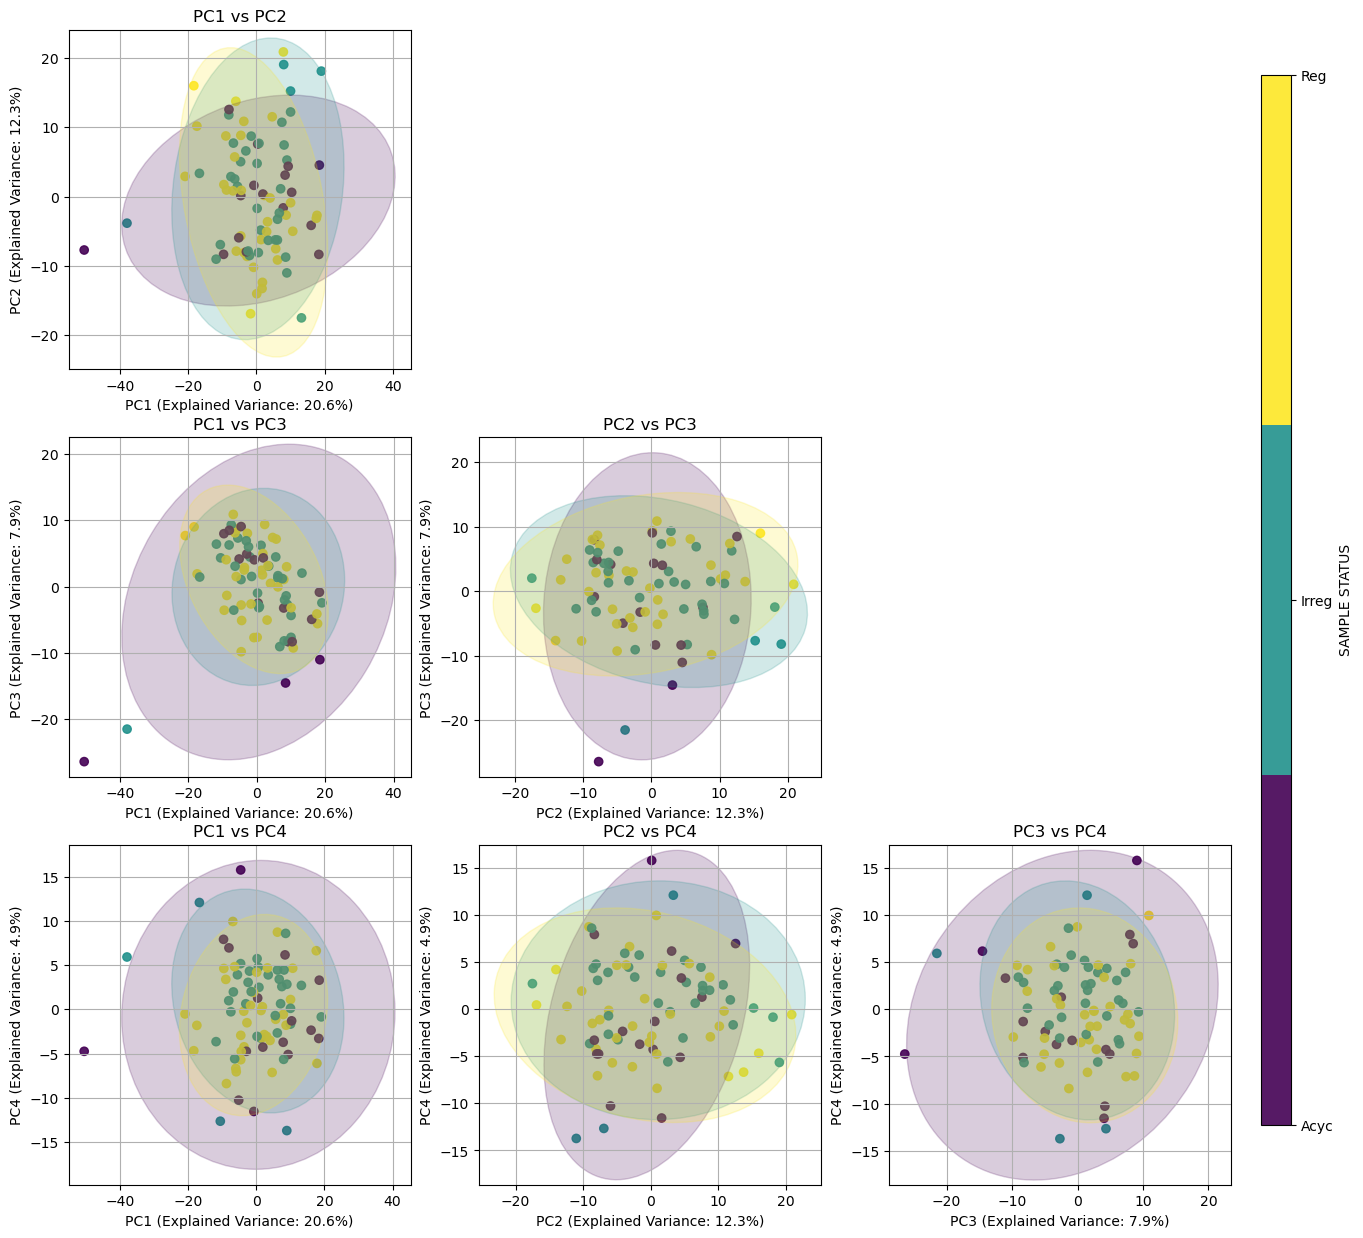

In [27]:
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue="SAMPLE STATUS",alpha_dot=0.9,save_path="status_"+tag+".pdf")

In [28]:
metadata.columns

Index(['CLIENT IDENTIFIER', 'AMOUNT EXTRACTED CLP', 'BOX NUMBER',
       'CLIENT MATRIX', 'CLIENT SAMPLE ID', 'CLIENT SAMPLE NUMBER', 'GENOTYPE',
       'GROUP ID', 'GROUP NAME', 'GROUP NUMBER', 'SAMPLE AMOUNT',
       'SAMPLE AMOUNT UNITS', 'SAMPLE BOX LOCATION', 'SAMPLE DESCRIPTION',
       'SAMPLE STATUS', 'TIMEPOINT'],
      dtype='object')

Plot saved as TIMEPOINT_lipid_concentration.pdf


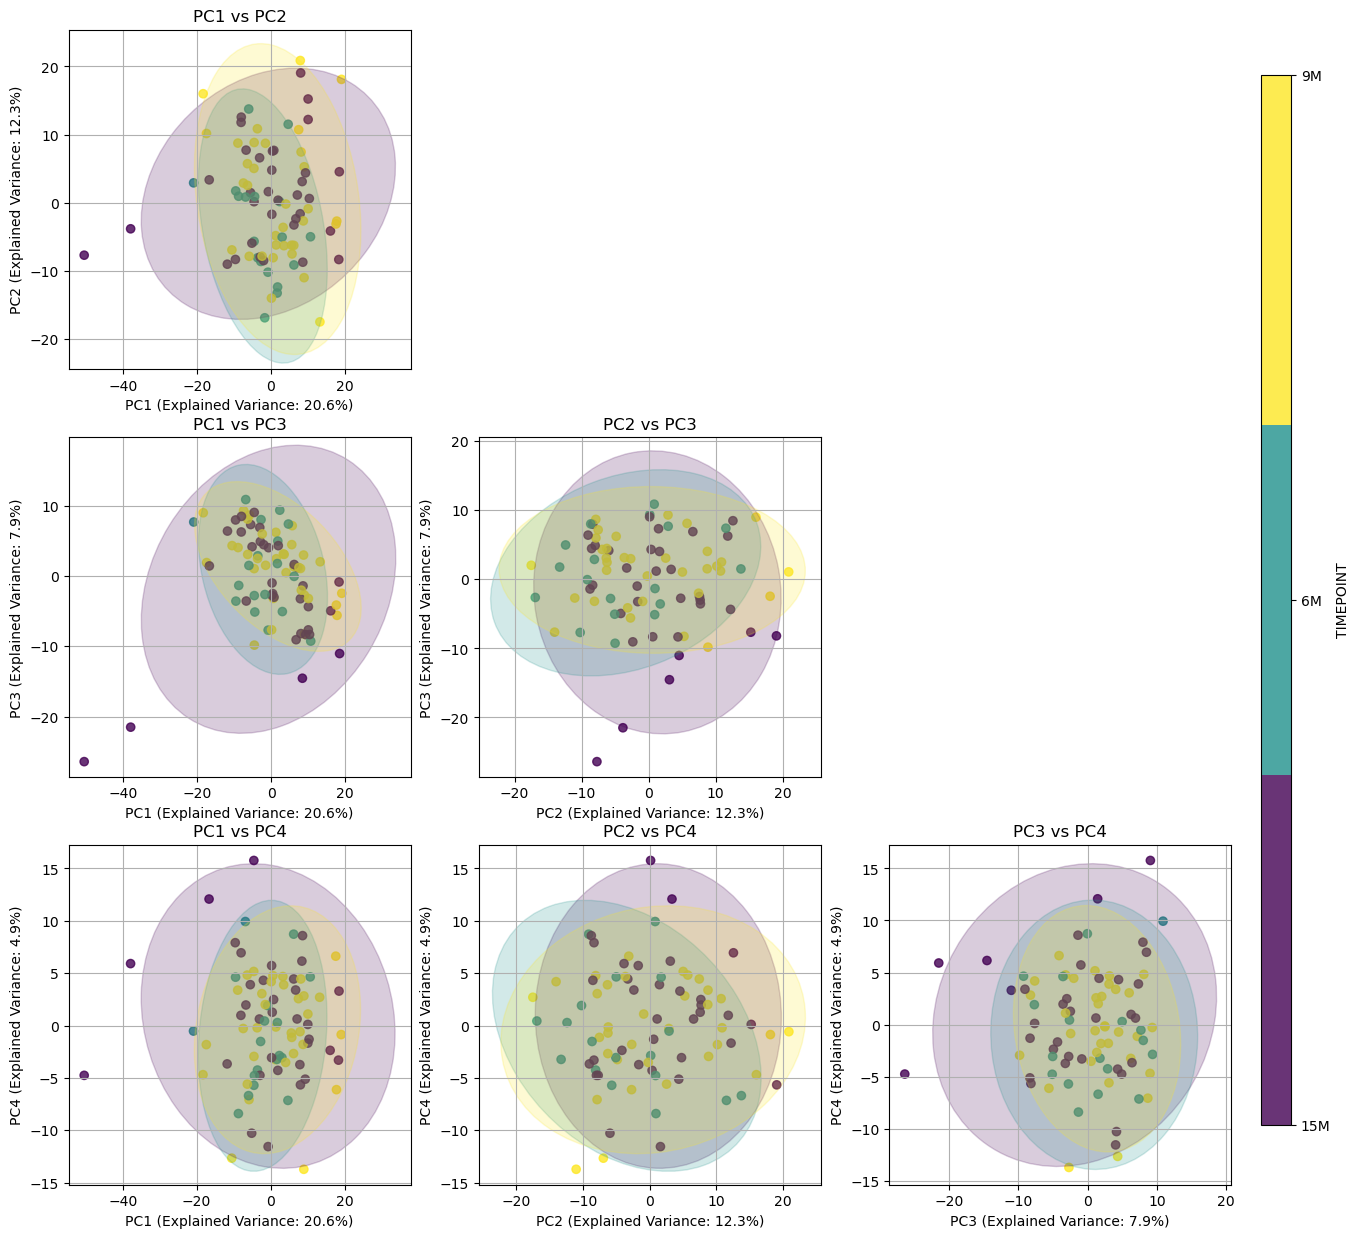

In [29]:
col_select = "TIMEPOINT"
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue=col_select,save_path=col_select+"_"+tag+".pdf")

Plot saved as TIMEPOINT_lipid_concentration.pdf


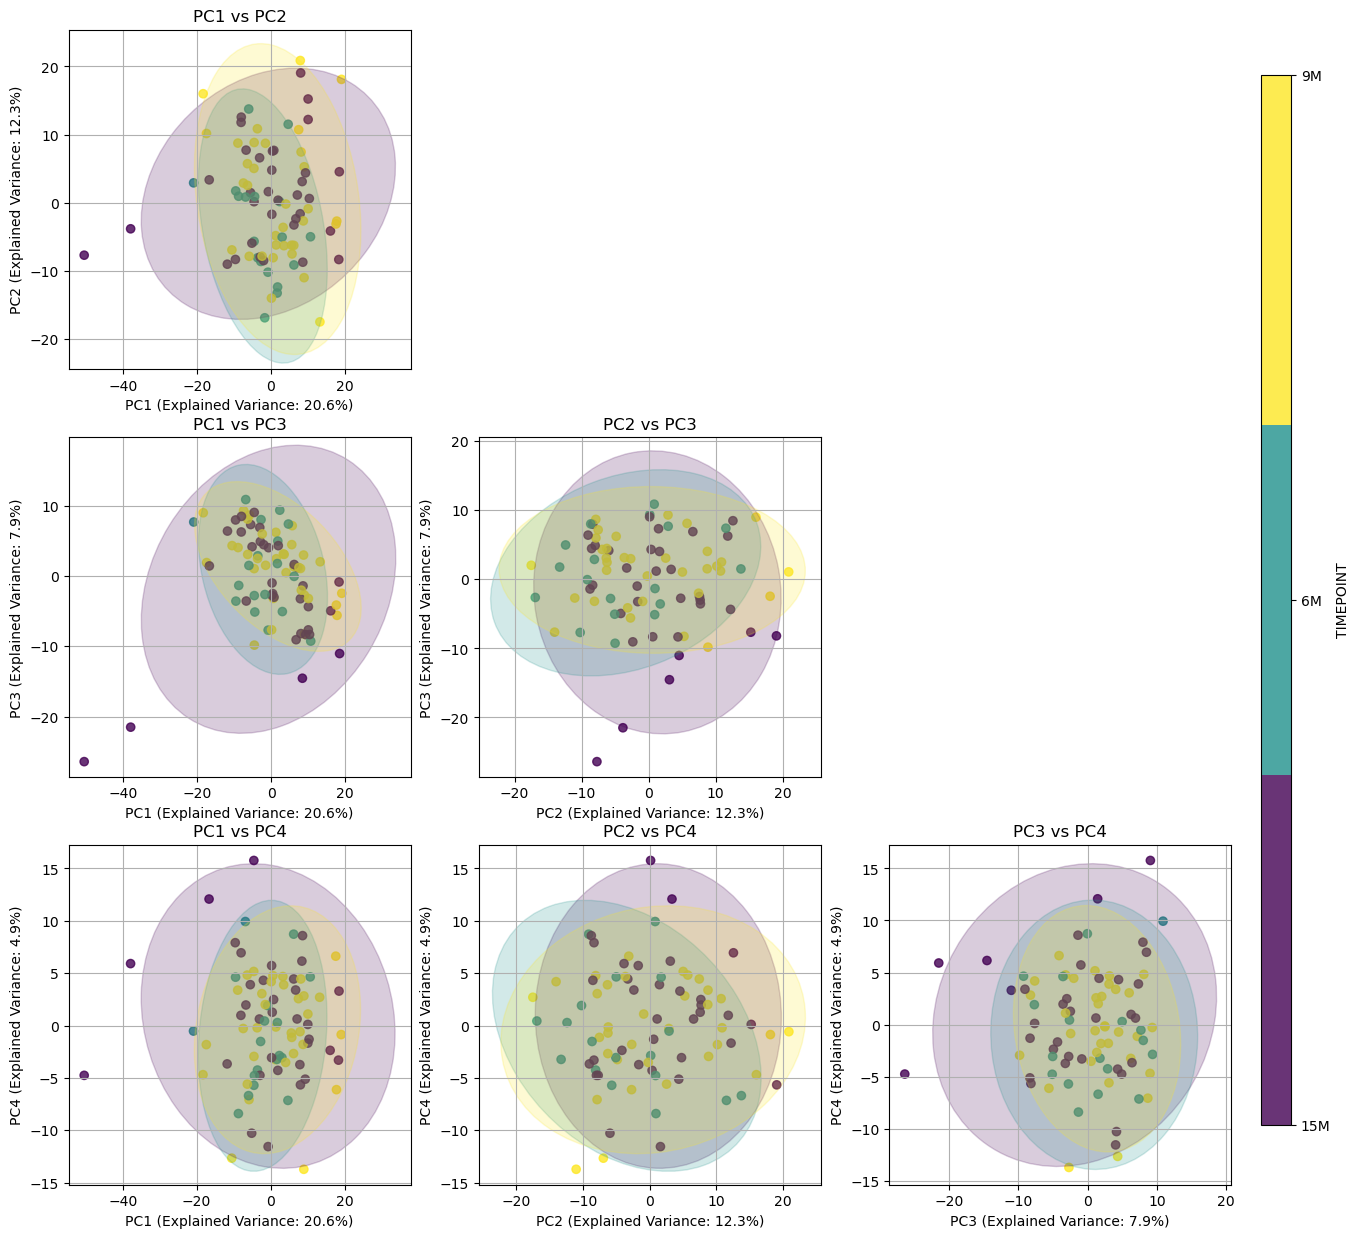

In [30]:
col_select = "TIMEPOINT"
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue=col_select,save_path=col_select+"_"+tag+".pdf")

Plot saved as GENOTYPE_lipid_concentration.pdf


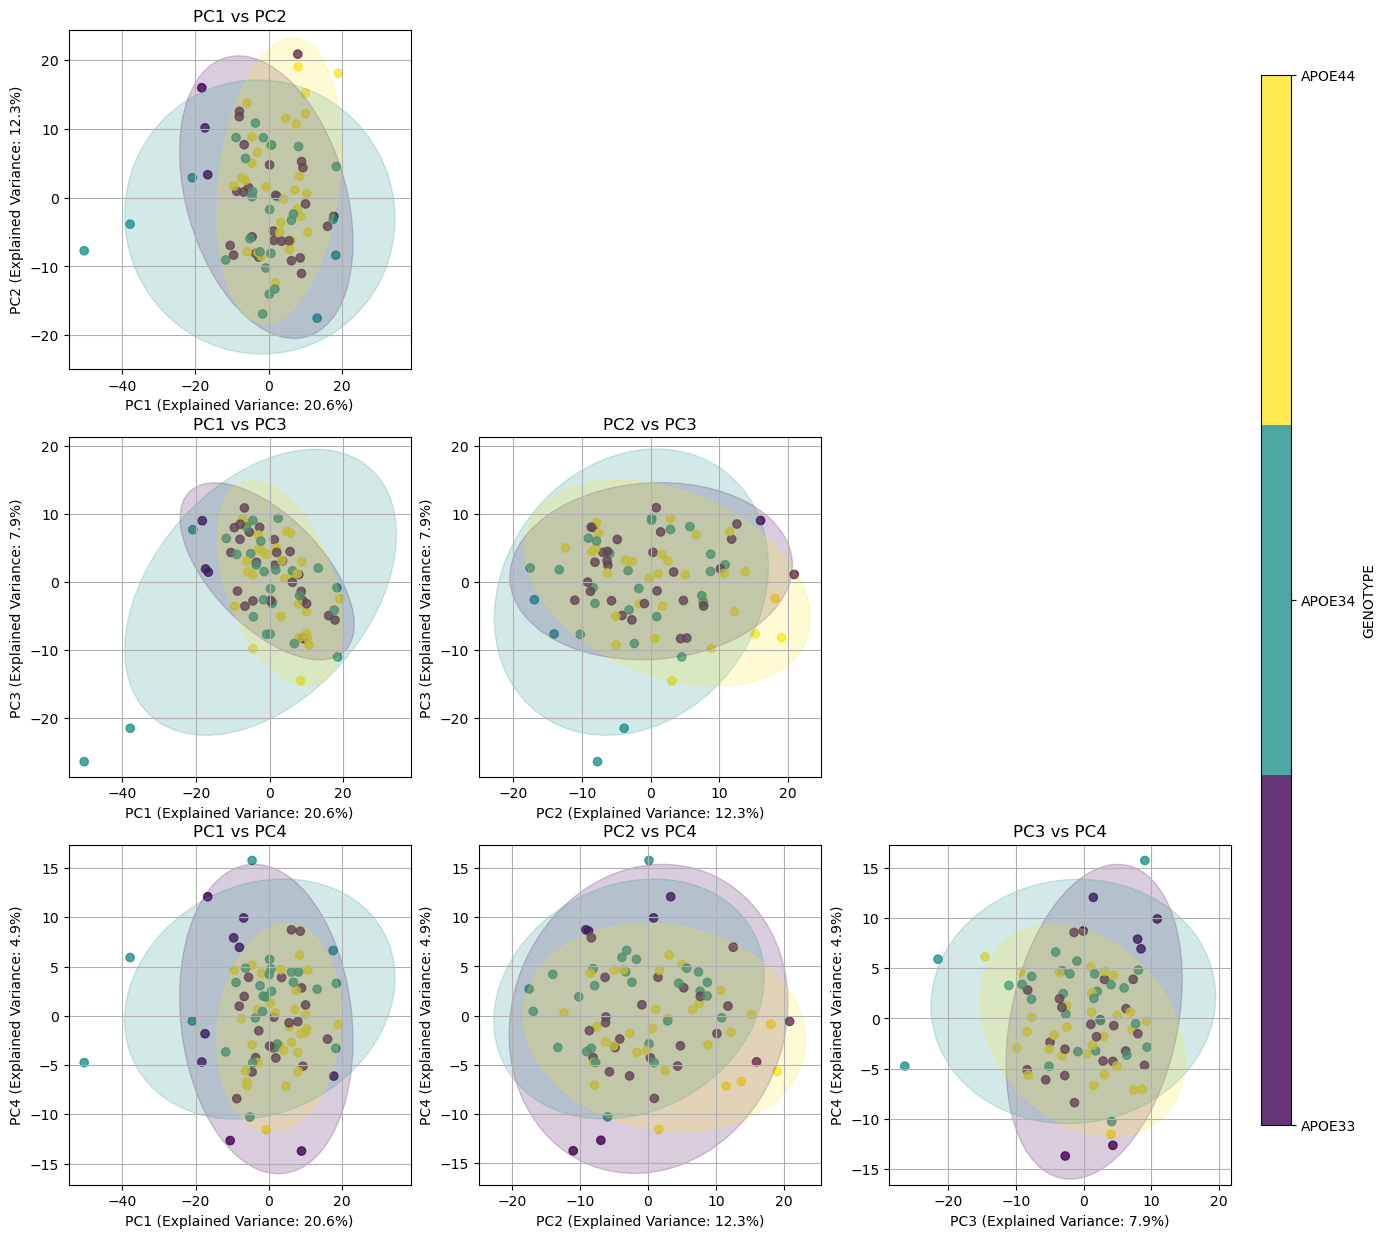

In [31]:
col_select = "GENOTYPE"
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue=col_select,save_path=col_select+"_"+tag+".pdf")

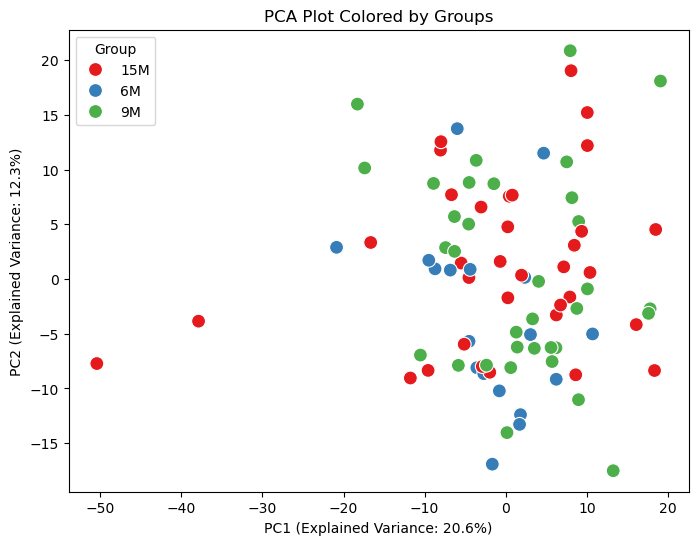

In [32]:
# Plot the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1", y="PC2", hue="TIMEPOINT", data=pca_df, palette="Set1", s=100
)
plt.title("PCA Plot Colored by Groups")
plt.xlabel(f"PC1 (Explained Variance: {100*pca.explained_variance_ratio_[0]:.1f}%)")
plt.ylabel(f"PC2 (Explained Variance: {100*pca.explained_variance_ratio_[1]:.1f}%)")
plt.legend(title="Group")
plt.show()